In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re #Regular Expressions
import string #importing string functions
import nltk
nltk.download('wordnet')
from nltk.util import ngrams
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

### **Read Data**

In [4]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [6]:
text_df['Review'] = text_df['Title']+ ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [7]:
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})

### **Remove Missing Values**

In [8]:
#detect missing values in data
text_df.Review.isna().sum()

3811

In [9]:
#drop null values
text_df.dropna(inplace=True)
text_df.head()
print("After dropping NaN text_df: ",text_df.shape)

After dropping NaN text_df:  (19675, 2)


In [10]:
text_df.head()

,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


### **Remove Duplicates**

In [11]:
print("Before dropping text_df: ",text_df.shape)
text_df.drop_duplicates(inplace = True)
print("After dropping text_df: ",text_df.shape)

Before dropping text_df:  (19675, 2)
After dropping text_df:  (19671, 2)


In [12]:
text_df.isnull().sum(axis=0).sort_values()

Recommended    0
Review         0
dtype: int64

In [13]:
text_df['Recommended'].value_counts()

Recommended
1    16096
0     3575
Name: count, dtype: int64

In [14]:
from sklearn.utils import resample

#create two different dataframe of majority and minority class
df_majority = text_df[(text_df['Recommended']==1)]
df_minority = text_df[(text_df['Recommended']==0)]

# upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples=15539 , # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
df_upsampled

,Recommended,Review
20700,0,Very large; lace is kinda coarse Thought i'd l...
23020,0,Way too much fabric I wanted to love this jump...
5625,0,So surprised by the poor quality I loved the l...
8695,0,"Runs large I so wanted to love this tank, and ..."
7689,0,"If you have a chest, beware I got this top in ..."
...,...,...
23479,1,What a fun piece! So i wasn't sure about order...
23481,1,Great dress for many occasions I was very happ...
23482,1,Wish it was made of cotton It reminds me of ma...
23484,1,"Very cute dress, perfect for summer parties an..."


### **Data Preprocessing**

In [15]:
#removes pattern in the input text
#re.findall use to find all patterns in the text
# re.sub uses to  substitue each pattern that found in the text and replace it with empty string
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [16]:
#\w means [a to Z] and umbers ftom [0-9]
#and this code means to remove any word after @
df_upsampled["Cleaned_Review"] = np.vectorize(remove_pattern)(df_upsampled["Review"], "@[\w]*")

In [17]:
#Remove special characters, numbers and punctuations
#that code replace any letter that not a character with space "empty string"
df_upsampled["Cleaned_Review"] = df_upsampled["Cleaned_Review"].str.replace("[^a-zA-Z]", " ")
text_df.head()

,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [18]:
#Removing short words (words with length less than 3)
#The lambda function is splitting each review into individual words and then only keeping words that have a length greater than 3 characters and then join these word by putting a space between them
df_upsampled["Cleaned_Review"] = df_upsampled["Cleaned_Review"].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df_upsampled.head()

,Recommended,Review,Cleaned_Review
20700,0,Very large; lace is kinda coarse Thought i'd l...,Very large; lace kinda coarse Thought love thi...
23020,0,Way too much fabric I wanted to love this jump...,much fabric wanted love this jumpsuit. looks a...
5625,0,So surprised by the poor quality I loved the l...,surprised poor quality loved look this sweater...
8695,0,"Runs large I so wanted to love this tank, and ...","Runs large wanted love this tank, excited mail..."
7689,0,"If you have a chest, beware I got this top in ...","have chest, beware this typical size medium wa..."


### **Data Visulization**

In [19]:
import pandas as pd
import plotly.express as px

# Count word frequencies
FreqOfWords = df_upsampled["Cleaned_Review"].str.split(expand=True).stack().value_counts()

# Select the top 200 words
FreqOfWords_top200 = FreqOfWords[:200]

# Convert to DataFrame for Plotly
FreqOfWords_top200_df = FreqOfWords_top200.reset_index()
FreqOfWords_top200_df.columns = ['word', 'count']

# Create a treemap
fig = px.treemap(FreqOfWords_top200_df, path=['word'], values='count', width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()


### **Text Manipulation**

In [20]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words=stopwords.words("english")
new_stopping_words = stop_words[:len(stop_words)-36]
new_stopping_words.remove("not")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **Noise Remonal**

In [21]:
#replace every n't with not
#replace every not alphanumeric character with space
def remove_punc(df):
    new_text= re.sub("n't",'not', df)
    new_text= re.sub('[^\w\s]','', df)
    return new_text

In [22]:
# processed_text=remove_punc(str(df["Review Text"]))
# processed_text
#call the method before
processed_text=remove_punc(str(df_upsampled["Cleaned_Review"]))
processed_text

'20700    Very large lace kinda coarse Thought love thi\n23020    much fabric wanted love this jumpsuit looks a\n5625     surprised poor quality loved look this sweater\n8695     Runs large wanted love this tank excited mail\n7689     have chest beware this typical size medium wa\n                                                       \n23479    What piece wasnt sure about ordering this sk\n23481    Great dress many occasions very happy snag thi\n23482    Wish made cotton reminds maternity clothes so\n23484    Very cute dress perfect summer parties bought\n23485    Please make more like this one This dress lov\nName Cleaned_Review Length 31635 dtype object'

### **Tokenization**

In [23]:
#split every review to words
def tokenizze(df):
    newdata= word_tokenize(df)
    return newdata

In [24]:
#call the method before and make all characters in lowercase
tokenized_data=tokenizze(processed_text.lower())
tokenized_data

['20700',
 'very',
 'large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'thi',
 '23020',
 'much',
 'fabric',
 'wanted',
 'love',
 'this',
 'jumpsuit',
 'looks',
 'a',
 '5625',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'this',
 'sweater',
 '8695',
 'runs',
 'large',
 'wanted',
 'love',
 'this',
 'tank',
 'excited',
 'mail',
 '7689',
 'have',
 'chest',
 'beware',
 'this',
 'typical',
 'size',
 'medium',
 'wa',
 '23479',
 'what',
 'piece',
 'wasnt',
 'sure',
 'about',
 'ordering',
 'this',
 'sk',
 '23481',
 'great',
 'dress',
 'many',
 'occasions',
 'very',
 'happy',
 'snag',
 'thi',
 '23482',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'so',
 '23484',
 'very',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 '23485',
 'please',
 'make',
 'more',
 'like',
 'this',
 'one',
 'this',
 'dress',
 'lov',
 'name',
 'cleaned_review',
 'length',
 '31635',
 'dtype',
 'object']

In [25]:
# its a function to remove all numeric data by checking every character using isalpha()
def remove_num(df):
    text_without_num=[w for w in df if w.isalpha()]
    return text_without_num

In [26]:
textwithoutnum= remove_num(tokenized_data)
textwithoutnum

['very',
 'large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'thi',
 'much',
 'fabric',
 'wanted',
 'love',
 'this',
 'jumpsuit',
 'looks',
 'a',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'this',
 'sweater',
 'runs',
 'large',
 'wanted',
 'love',
 'this',
 'tank',
 'excited',
 'mail',
 'have',
 'chest',
 'beware',
 'this',
 'typical',
 'size',
 'medium',
 'wa',
 'what',
 'piece',
 'wasnt',
 'sure',
 'about',
 'ordering',
 'this',
 'sk',
 'great',
 'dress',
 'many',
 'occasions',
 'very',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'so',
 'very',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 'please',
 'make',
 'more',
 'like',
 'this',
 'one',
 'this',
 'dress',
 'lov',
 'name',
 'length',
 'dtype',
 'object']

### **Remove stopWords**

In [27]:
def remove_stops(df):

    newdata=[t for t in df if t not in new_stopping_words]
    return newdata

In [28]:
data=remove_stops(textwithoutnum)
data

['large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'thi',
 'much',
 'fabric',
 'wanted',
 'love',
 'jumpsuit',
 'looks',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'sweater',
 'runs',
 'large',
 'wanted',
 'love',
 'tank',
 'excited',
 'mail',
 'chest',
 'beware',
 'typical',
 'size',
 'medium',
 'wa',
 'piece',
 'wasnt',
 'sure',
 'ordering',
 'sk',
 'great',
 'dress',
 'many',
 'occasions',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 'please',
 'make',
 'like',
 'one',
 'dress',
 'lov',
 'name',
 'length',
 'dtype',
 'object']

### **Stemming**

In [29]:
# Initialize the stemmer
stemmer = PorterStemmer()
# Stem each word and add to stemmed list
stemmed = []
for word in data:
    stemmed_word = stemmer.stem(word)
    stemmed.append(stemmed_word)

# Print original text and stemmed text

print(stemmed)

['larg', 'lace', 'kinda', 'coars', 'thought', 'love', 'thi', 'much', 'fabric', 'want', 'love', 'jumpsuit', 'look', 'surpris', 'poor', 'qualiti', 'love', 'look', 'sweater', 'run', 'larg', 'want', 'love', 'tank', 'excit', 'mail', 'chest', 'bewar', 'typic', 'size', 'medium', 'wa', 'piec', 'wasnt', 'sure', 'order', 'sk', 'great', 'dress', 'mani', 'occas', 'happi', 'snag', 'thi', 'wish', 'made', 'cotton', 'remind', 'matern', 'cloth', 'cute', 'dress', 'perfect', 'summer', 'parti', 'bought', 'pleas', 'make', 'like', 'one', 'dress', 'lov', 'name', 'length', 'dtype', 'object']


### **Lemmatization**

In [30]:
def lemmatizze(df):


    newdata= [WordNetLemmatizer().lemmatize(t) for t in df]
    return newdata


In [31]:
final_data=lemmatizze(stemmed)
final_data

['larg',
 'lace',
 'kinda',
 'coars',
 'thought',
 'love',
 'thi',
 'much',
 'fabric',
 'want',
 'love',
 'jumpsuit',
 'look',
 'surpris',
 'poor',
 'qualiti',
 'love',
 'look',
 'sweater',
 'run',
 'larg',
 'want',
 'love',
 'tank',
 'excit',
 'mail',
 'chest',
 'bewar',
 'typic',
 'size',
 'medium',
 'wa',
 'piec',
 'wasnt',
 'sure',
 'order',
 'sk',
 'great',
 'dress',
 'mani',
 'occas',
 'happi',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'remind',
 'matern',
 'cloth',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parti',
 'bought',
 'plea',
 'make',
 'like',
 'one',
 'dress',
 'lov',
 'name',
 'length',
 'dtype',
 'object']

In [32]:
joined_data=" ".join(final_data)
joined_data

'larg lace kinda coars thought love thi much fabric want love jumpsuit look surpris poor qualiti love look sweater run larg want love tank excit mail chest bewar typic size medium wa piec wasnt sure order sk great dress mani occas happi snag thi wish made cotton remind matern cloth cute dress perfect summer parti bought plea make like one dress lov name length dtype object'

N-gram for example only

In [33]:
# Tokenize the text
#tokens = nltk.word_tokenize(joined_data)

# Generate 2-grams
#bigrams = list(ngrams(tokens, 2))

# Generate 3-grams
#trigrams = list(ngrams(tokens, 3))

#print("Bigrams:", bigrams)
#print("Trigrams:", trigrams)

In [34]:
# Create bi-grams
#def get_bigrams(text):
    #tokens = nltk.word_tokenize(text)
    #bigrams_list = list(nltk.bigrams(tokens))
    #return [bigram[0] + ' ' + bigram[1] for bigram in bigrams_list]

#x = get_bigrams(joined_data)

#df = pd.DataFrame(x)
#pred  = pd.DataFrame({'Reviews': x,
#                      })

#print(len(pred))


### **Cleaning Data**

In [35]:
#def Cleaning_process(df):
    #processed_text=remove_punc(str(df))
    #tokenized_data=tokenizze(processed_text.lower())
    #textwithoutnum= remove_num(tokenized_data)
    #data=remove_stops(textwithoutnum)
    #final_data=lemmatizze(data)
    #return " ".join(final_data)

In [36]:
#text = Cleaning_process(str(df_upsampled["Cleaned_Review"]))
#text

In [37]:
#df_upsampled["Cleaned_Review"]= df_upsampled["Cleaned_Review"].apply(Cleaning_process)

In [38]:
df_upsampled.head()

,Recommended,Review,Cleaned_Review
20700,0,Very large; lace is kinda coarse Thought i'd l...,Very large; lace kinda coarse Thought love thi...
23020,0,Way too much fabric I wanted to love this jump...,much fabric wanted love this jumpsuit. looks a...
5625,0,So surprised by the poor quality I loved the l...,surprised poor quality loved look this sweater...
8695,0,"Runs large I so wanted to love this tank, and ...","Runs large wanted love this tank, excited mail..."
7689,0,"If you have a chest, beware I got this top in ...","have chest, beware this typical size medium wa..."


In [39]:
import pandas as pd
import plotly.express as px

# Assume df_upsampled is already defined
# Count word frequencies
FreqOfWords = df_upsampled["Cleaned_Review"].str.split(expand=True).stack().value_counts()

# Select the top 200 words
FreqOfWords_top200 = FreqOfWords[:200]

# Convert to DataFrame for Plotly
FreqOfWords_top200_df = FreqOfWords_top200.reset_index()
FreqOfWords_top200_df.columns = ['word', 'count']

# Create a treemap
fig = px.treemap(FreqOfWords_top200_df, path=['word'], values='count', width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()


### **Word Cloud**

In [40]:
pip install wordcloud

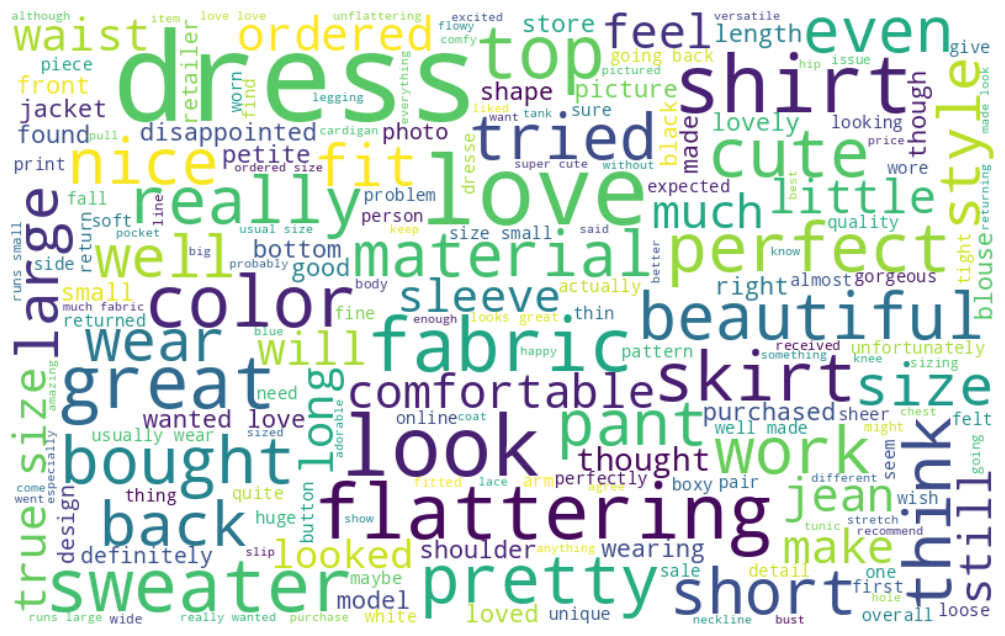

In [41]:
#Visualizing the Keywords
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

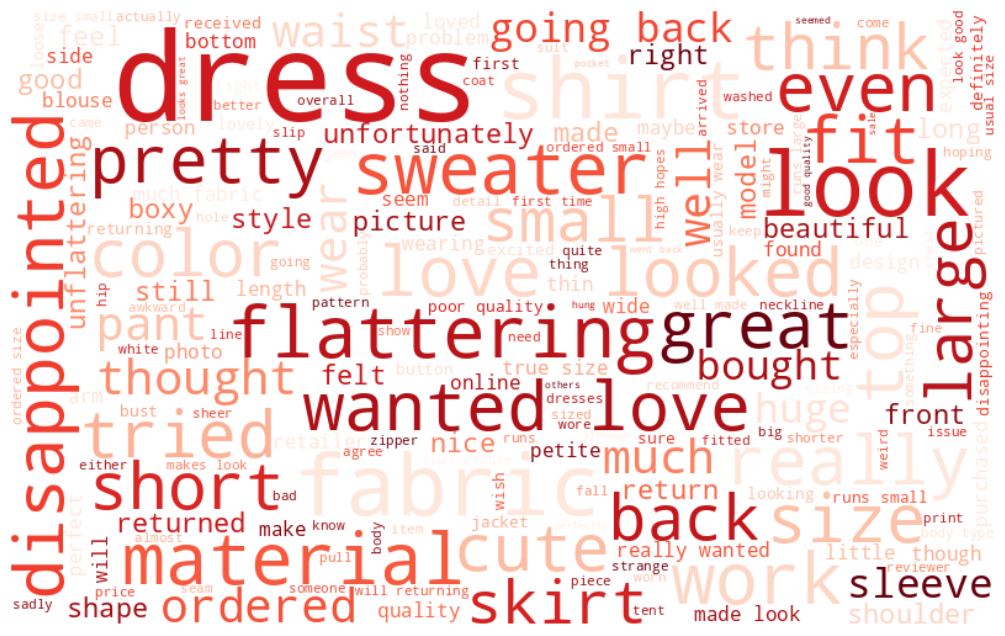

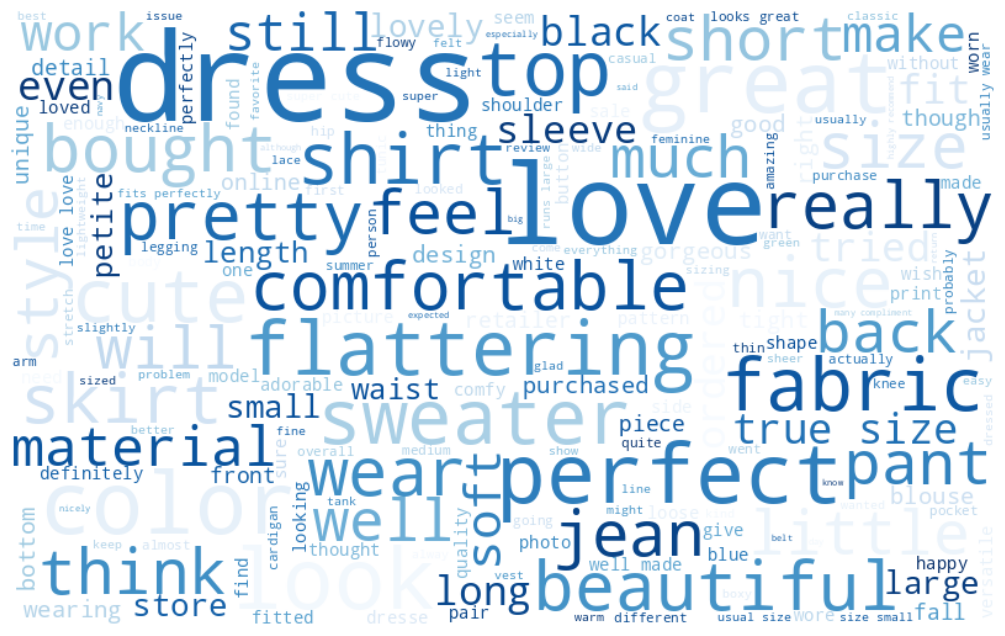

In [42]:

#Frequent words visualization for negative label
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"][df_upsampled["Recommended"]==0]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',colormap= 'Reds', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()
#Frequent words visualization for Positive Review
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"][df_upsampled["Recommended"]==1]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white',colormap='Blues', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### **Splitting Data**

In [43]:
#importing
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
 #TF-IDF are word frequency scores that try to highlight words that are more interesting,

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
vectorizer2 = CountVectorizer(ngram_range=(2, 2))

x = df_upsampled["Cleaned_Review"]
y = df_upsampled["Recommended"]


In [45]:
#tokenization

from keras.preprocessing.text import Tokenizer
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x)
xtokens= tokenizer.texts_to_sequences(x)

In [46]:
#padding

#from tensorflow.keras.preprocessing.sequence import pad_sequences

#maxlen=50
#xpad=pad_sequences(xtokens,padding='post', maxlen=maxlen)

In [47]:
#train_test splot
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,random_state=42)

In [48]:
X_train_ngrams = vectorizer2.fit_transform(x_train)
X_test_ngrams = vectorizer2.transform(x_test)

### **Supervised Models**

In [49]:
accuracy_list = []
f1_list = []
roc_auc_list = []

In [50]:
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
from sklearn.linear_model import LogisticRegression
plt=reload(plt)

In [51]:
def result(model):


    #fit on data
    model.fit(X_train_ngrams, y_train)

    #prediction
    pred = model.predict(X_test_ngrams)

    # Create new DataFrame with original features and predicted values
    df = pd.DataFrame(data)
    predictions  = pd.DataFrame({'Reviews': x_test,
                                'predicted_values': pred})

    print(predictions.head(50))
    print()

    #performance of model
    print("Classification Report: \n", classification_report(y_test, pred))
    print("-" * 100)
    print()

    #accuracy of model
    acc = accuracy_score(y_test, pred)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()

    #f1-score of model
    f1 = f1_score(y_test, pred)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()

    #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(y_test,pred)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(y_test, pred)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()

    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
    plt.title('Confusion Matrix', fontsize=20)




### **Logistic Regression**

In [52]:
lr = LogisticRegression()


                                                 Reviews  predicted_values
8870   work loved color this shirt does big. even siz...                 0
17874  Perfect flowy would describe upgraded t-shirt....                 1
13374  Hook issues With glowing reviews this dress, b...                 0
16452  Huge ordered online it's still massive. only t...                 0
23121  Cute Cute design casual top. however little sn...                 1
5555   Love it's itchy! This shirt aesthetically very...                 0
20750  Another synthetic fabric... disappointed abund...                 0
1373   Very delicate Cute started disintegrating afte...                 0
2406   great This pulled across shoulders neck creepy...                 0
14356  Beautiful aesthetic, crazy construction 5'7", ...                 1
815    Pretty just okay when worn. love back detail d...                 0
9621   Excellent have chest received this today will ...                 0
2681   Whoa vanity sizing

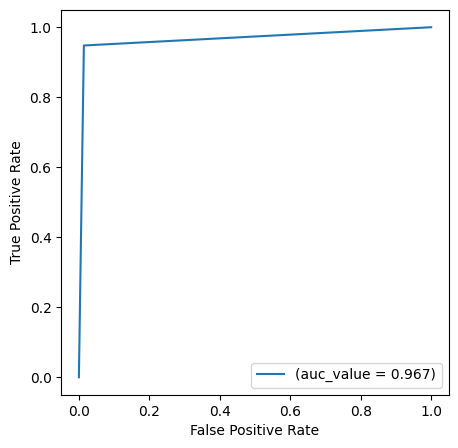


Confusion Matrix: 


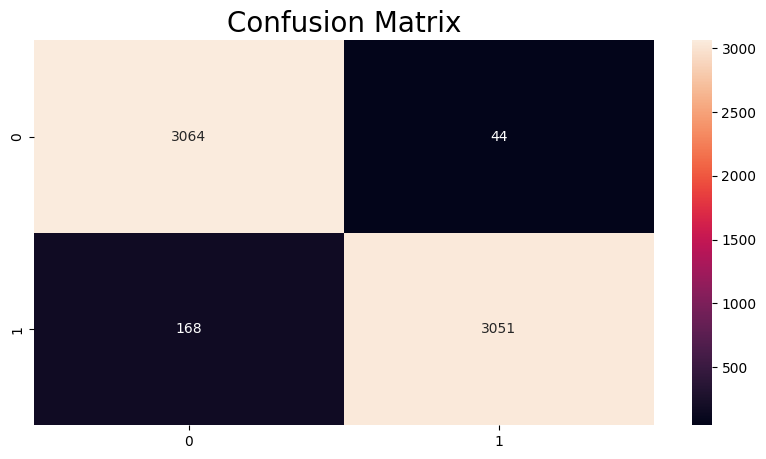

In [53]:
result(lr)

In [54]:
# Predict the sentiment of a new review using the trained model
new_review = "I like this t-shirt"
new_review_features = vectorizer2.transform([new_review])
prediction = lr.predict(new_review_features)[0]
if prediction == 1:
    print('Positive review')
else:
    print('Negative review')

Positive review


In [55]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

class SentimentAnalyzer:
    def __init__(self):
        self.pipeline = self._create_pipeline()

    def _create_pipeline(self):
        return make_pipeline(
            TfidfVectorizer(preprocessor=self.preprocess_text, tokenizer=self.additional_preprocessing),
            LogisticRegression()
        )

    def preprocess_text(self, text):
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.strip()
        return text

    def additional_preprocessing(self, text):
        text = re.sub("n't", 'not', text)
        text = re.sub('[^\w\s]', '', text)
        tokens = word_tokenize(text.lower())
        tokens = [w for w in tokens if w.isalpha()]
        stop_words = set(stopwords.words("english"))
        stop_words.remove("not")
        tokens = [t for t in tokens if t not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(tokens)

    def train(self, X_train, y_train):
        self.pipeline.fit(X_train, y_train)

    def predict_sentiment(self, review):
        return 'Positive review' if self.pipeline.predict([review])[0] == 1 else 'Negative review'

# Example usage:
if __name__ == "__main__":
    # Assuming you have training data X_train, y_train
    sentiment_analyzer = SentimentAnalyzer()
    sentiment_analyzer.train(x_train, y_train)

    new_reviews = [
        "I love this t-shirt",
        "I don't like this t-shirt"
    ]

    for review in new_reviews:
        print("Review:", review)
        print("Prediction:", sentiment_analyzer.predict_sentiment(review))
        print()


Review: I love this t-shirt
Prediction: Positive review

Review: I don't like this t-shirt
Prediction: Negative review



### SVM

Support Vector Machine (SVM) Results:
                                                 Reviews  predicted_values
8870   work loved color this shirt does big. even siz...                 0
17874  Perfect flowy would describe upgraded t-shirt....                 1
13374  Hook issues With glowing reviews this dress, b...                 0
16452  Huge ordered online it's still massive. only t...                 0
23121  Cute Cute design casual top. however little sn...                 1
5555   Love it's itchy! This shirt aesthetically very...                 0
20750  Another synthetic fabric... disappointed abund...                 0
1373   Very delicate Cute started disintegrating afte...                 0
2406   great This pulled across shoulders neck creepy...                 0
14356  Beautiful aesthetic, crazy construction 5'7", ...                 1
815    Pretty just okay when worn. love back detail d...                 0
9621   Excellent have chest received this today will ...      

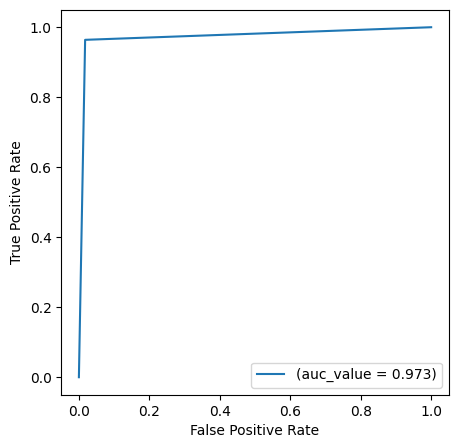


Confusion Matrix: 


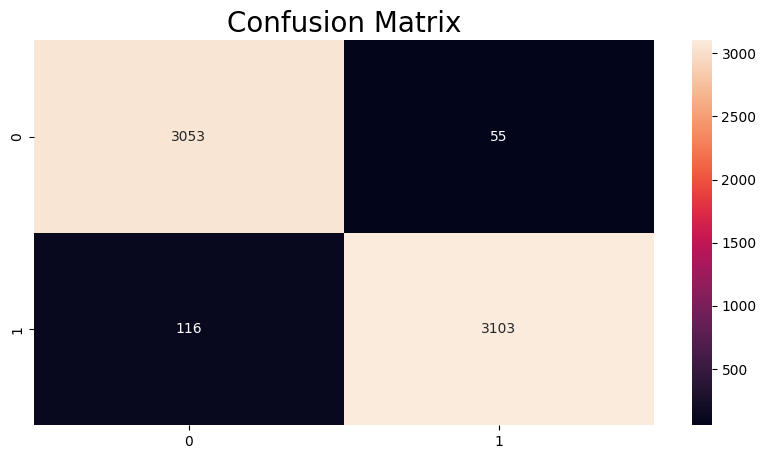

In [56]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Support Vector Machine (SVM)
svm = SVC()

print("Support Vector Machine (SVM) Results:")
result(svm)


### Decision Tree

Decision Tree Results:
                                                 Reviews  predicted_values
8870   work loved color this shirt does big. even siz...                 0
17874  Perfect flowy would describe upgraded t-shirt....                 1
13374  Hook issues With glowing reviews this dress, b...                 0
16452  Huge ordered online it's still massive. only t...                 0
23121  Cute Cute design casual top. however little sn...                 1
5555   Love it's itchy! This shirt aesthetically very...                 0
20750  Another synthetic fabric... disappointed abund...                 0
1373   Very delicate Cute started disintegrating afte...                 0
2406   great This pulled across shoulders neck creepy...                 0
14356  Beautiful aesthetic, crazy construction 5'7", ...                 0
815    Pretty just okay when worn. love back detail d...                 0
9621   Excellent have chest received this today will ...                 0
26

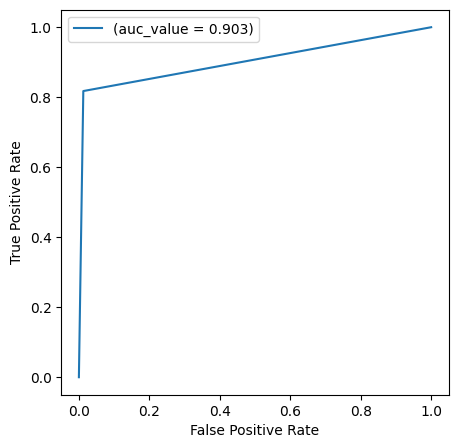


Confusion Matrix: 


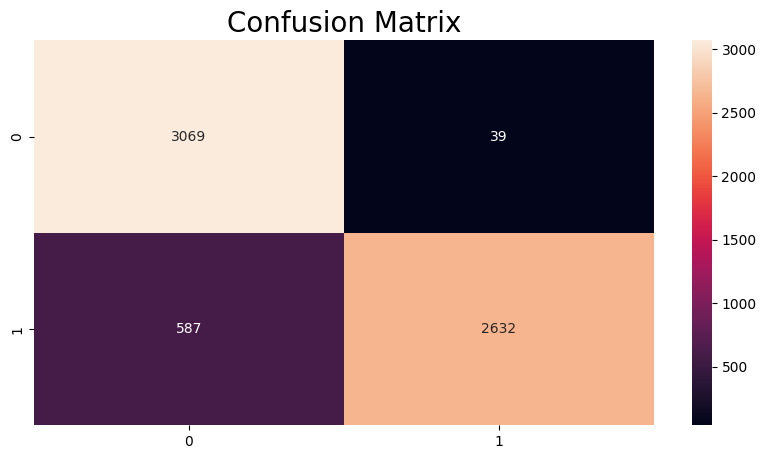

In [57]:
# Decision Tree
dt = DecisionTreeClassifier()

print("Decision Tree Results:")
result(dt)